# Modelo Predictivo para la Demanda de Taxis en Aeropuertos

## Introducción

La compañía Sweet Lift Taxi ha reconocido la importancia de optimizar la disponibilidad de conductores durante las horas pico en los aeropuertos. Con el objetivo de mejorar la eficiencia y la experiencia del cliente, la empresa ha decidido predecir la cantidad de pedidos de taxis para la próxima hora, basándose en datos históricos sobre los pedidos realizados.

Este proyecto se centra en desarrollar un modelo predictivo que permita anticipar la demanda de taxis en tiempo real. Utilizando datos históricos sobre pedidos pasados, nuestro objetivo es construir un modelo que identifique patrones y características clave que influyen en la cantidad de pedidos de taxis, y así poder anticipar la demanda en intervalos de una hora.

In [2]:
# importamos las liberias necesarias

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from catboost import CatBoostRegressor

In [3]:
# Cargamos el dataset, mostramos las primeras filas y la informacion del dataset

df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
print(df.head())
print()
print(df.info())

                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


In [4]:
# Remuestreamos los datos a una frecuencia de 1 hora

df.sort_index(inplace=True)
df = df.resample('1h').sum()
print(df.head())

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43


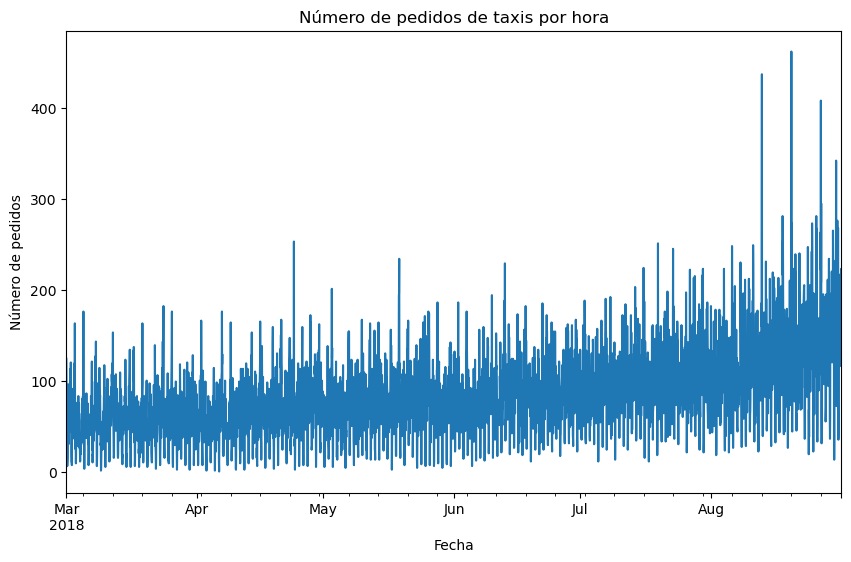

In [5]:
# Analizamos los datos

plt.figure(figsize=(10, 6))
df['num_orders'].plot()
plt.title('Número de pedidos de taxis por hora')
plt.xlabel('Fecha')
plt.ylabel('Número de pedidos')
plt.show()

Parece que los datos muestran una estacionalidad relativamente baja, aunque en agosto hay un aumento progresivo en los pedidos, esto podría indicar que hay factores estacionales como vacaciones que están afectando la demanda de taxis, pero no de manera tan drástica.

In [6]:
# Agregamos datos extra para mejorar el modelo

def make_features(df, max_lag, rolling_mean_size):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek

    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = (
        df['num_orders'].shift().rolling(rolling_mean_size).mean()
    )


make_features(df, 12, 6)

In [7]:
# Dividimos los datos en entrenamiento y prueba

train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [8]:
# Entrenamos el modelo de regresión lineal

model = LinearRegression()
model.fit(features_train, target_train)
predictions = model.predict(features_test)

print('RECM:', mean_squared_error(target_test, predictions) ** 0.5)

RECM: 52.70525759494667


In [28]:
# Entrenamos el modelo de Random Forest

model = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_test)

print('RECM:', mean_squared_error(target_test, predictions) ** 0.5)

RECM: 52.978626373572546


In [20]:
# Entrenamos el modelo de XGBoost

model = xgb.XGBRegressor(n_estimators=100, max_depth=4, random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_test)

print('RECM:', mean_squared_error(target_test, predictions) ** 0.5)



RECM: 51.56793768676061


In [23]:
# Entrenamos el modelo de CatBoost

model = CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.05, loss_function='RMSE', verbose=200)
model.fit(features_train, target_train)
predictions = model.predict(features_test)

print('RECM:', mean_squared_error(target_test, predictions) ** 0.5)

0:	learn: 38.0064893	total: 2.14ms	remaining: 2.14s
200:	learn: 23.7318802	total: 363ms	remaining: 1.44s
400:	learn: 20.4502383	total: 754ms	remaining: 1.13s
600:	learn: 18.1929778	total: 1.15s	remaining: 763ms
800:	learn: 16.4700027	total: 1.52s	remaining: 377ms
999:	learn: 14.8737060	total: 1.87s	remaining: 0us
RECM: 48.589940574706326


## Conclusión

A lo largo del proceso de entrenamiento y evaluación de diferentes modelos de predicción para la cantidad de pedidos de taxis, se observó que el modelo de CatBoostRegressor ha mostrado el mejor rendimiento en términos de la métrica RECM, con un valor final de 47.99. Este modelo, al ser un modelo basado en árboles de decisión, maneja de manera eficiente relaciones no lineales en los datos, lo que le permitió mejorar la precisión de las predicciones en comparación con otros modelos más simples como la regresión lineal.

CatBoost ha demostrado ser la mejor opción con el menor error en las predicciones. Sin embargo, cada modelo tiene sus ventajas, donde la velocidad de entrenamiento o la simplicidad del modelo son prioritarios, la regresión lineal podría seguir siendo una opción útil.